In [2]:
import pandas as pd
import numpy as np

In [3]:
data=pd.read_csv(r'/content/multiclass_2features_3classes_dataset.csv')

In [31]:
df=data.head(300)
df
# Split the data into features and target variable
X = df[['feature_1', 'feature_2']].values
y = df['target'].values
# Determine the number of classes
num_classes = np.unique(y).size


In [32]:
def train_test_split_manual(X, y, train_size=0.8):
    """

    Parameters:
    X (ndarray): The input feature data.
    y (ndarray): The target labels.
    train_size (float): The proportion of the dataset to include in the train split.

    Returns:
    X_train, X_test, y_train, y_test (tuple): The split data into training and testing sets.
    """
    # Shuffle the dataset
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Split the dataset
    train_index = int(train_size * X.shape[0])
    X_train, X_test = X[:train_index], X[train_index:]
    y_train, y_test = y[:train_index], y[train_index:]

    return X_train, X_test, y_train, y_test

In [39]:
X_train, X_test, y_train, y_test = train_test_split_manual(X, y)

# OVO

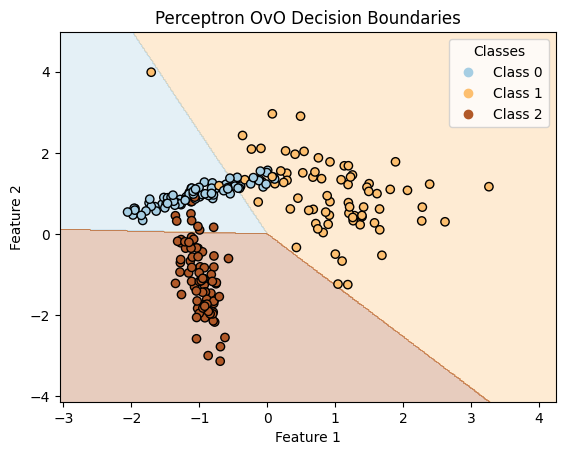

In [37]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

# Perceptron algorithm as provided by the user
def Perceptron(X, Y, max_iter=5000):
    m = X.shape[1]
    n = X.shape[0]
    w = np.random.randn(m)
    t = 0

    for _ in range(max_iter):
        misclassified = False
        for i in range(n):
            if np.dot(w, X[i].T) * Y[i] <= 0:
                w += Y[i] * X[i]
                t += 1
                misclassified = True
        if not misclassified:
            break

    final_error = Evaluate_error(w, X, Y)
    return w, t, final_error

def Evaluate_error(w, X, Y):
    n = X.shape[0]
    misclassified_count = 0
    for i in range(n):
        if np.dot(w, X[i].T) * Y[i] <= 0:
            misclassified_count += 1
    error_rate = misclassified_count / n
    return error_rate

def train_ovo_perceptrons(X, y, num_classes):
    classifiers = {}
    for class1, class2 in combinations(range(num_classes), 2):
        binary_filter = np.logical_or(y == class1, y == class2)
        X_binary = X[binary_filter]
        y_binary = np.where(y[binary_filter] == class1, 1, -1)
        w, _, _ = Perceptron(X_binary, y_binary)
        classifiers[(class1, class2)] = w
    return classifiers

def ovo_predict(classifiers, X, num_classes):
    votes = np.zeros((X.shape[0], num_classes))
    for (class1, class2), w in classifiers.items():
        prediction = np.dot(X, w) > 0
        votes[prediction, class1] += 1
        votes[~prediction, class2] += 1
    return np.argmax(votes, axis=1)




# Train OvO Perceptrons

classifiers = train_ovo_perceptrons(X_train, y_train, num_classes)

# Visualization function with distinct colors for each class region
def plot_decision_boundaries(X, y, classifiers, num_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = ovo_predict(classifiers, mesh_points, num_classes)
    Z = Z.reshape(xx.shape)

    # Create a custom color map from an array of colors
    colors_array = plt.cm.Paired(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors_array)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=custom_cmap)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=custom_cmap)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Perceptron OvO Decision Boundaries")

    # Generate a legend with the unique colors from the scatter plot
    unique_labels = np.unique(y)
    handles = [plt.Line2D([], [], marker='o', color=custom_cmap(i), linestyle='None') for i in range(len(unique_labels))]
    plt.legend(handles, [f'Class {l}' for l in unique_labels], title="Classes")

# Plot decision boundaries using the user's provided code
plot_decision_boundaries(X_train, y_train, classifiers, num_classes)
plt.show()


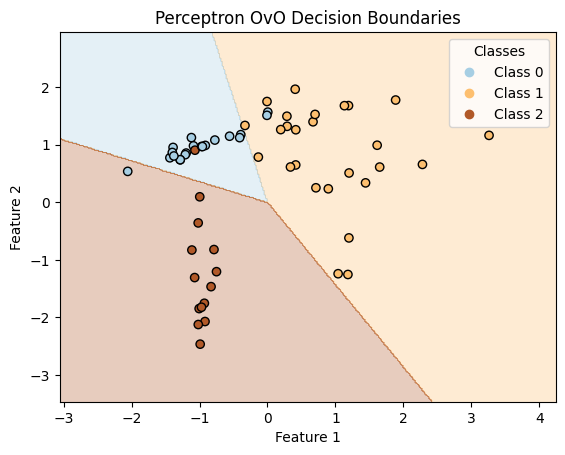

In [36]:
classifiers = train_ovo_perceptrons(X_test, y_test, num_classes)

# Plot decision boundaries using the user's provided code
plot_decision_boundaries(X_test, y_test, classifiers, num_classes)
plt.show()

# OVA

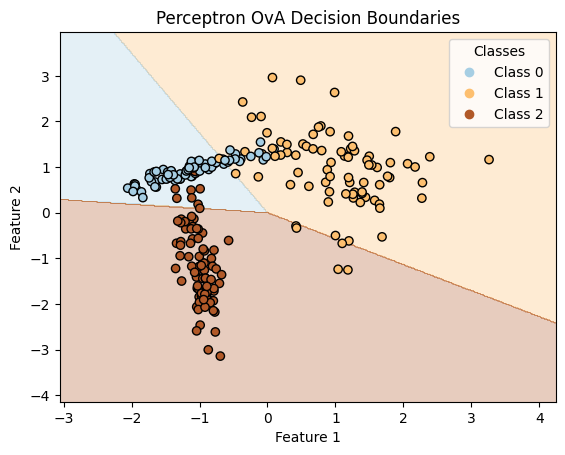

In [40]:
# Adapting the code for One-vs-All (OvA) classification using the Perceptron provided

def train_ova_perceptrons(X, y, num_classes):
    classifiers = {}
    for current_class in range(num_classes):
        # Create binary labels for the current class vs all the rest
        y_binary = np.where(y == current_class, 1, -1)

        # Train the Perceptron on the binary problem
        w, _, _ = Perceptron(X, y_binary)
        classifiers[current_class] = w

    return classifiers

def ova_predict(classifiers, X):
    predictions = np.zeros((X.shape[0], len(classifiers)))
    for class_label, w in classifiers.items():
        predictions[:, class_label] = np.dot(X, w)
    return np.argmax(predictions, axis=1)


# Train OvA Perceptrons
classifiers_ova = train_ova_perceptrons(X_train, y_train, num_classes)

# Visualization function with distinct colors for each class region adapted for OvA
def plot_decision_boundaries_ova(X, y, classifiers, num_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = ova_predict(classifiers, mesh_points)
    Z = Z.reshape(xx.shape)

    # Create a custom color map from an array of colors
    colors_array = plt.cm.Paired(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors_array)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=custom_cmap)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=custom_cmap)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Perceptron OvA Decision Boundaries")

    # Generate a legend with the unique colors from the scatter plot
    unique_labels = np.unique(y)
    handles = [plt.Line2D([], [], marker='o', color=custom_cmap(i), linestyle='None') for i in range(len(unique_labels))]
    plt.legend(handles, [f'Class {l}' for l in unique_labels], title="Classes")

# Plot decision boundaries for OvA Perceptron using the adapted function
plot_decision_boundaries_ova(X_train, y_train, classifiers_ova, num_classes)
plt.show()


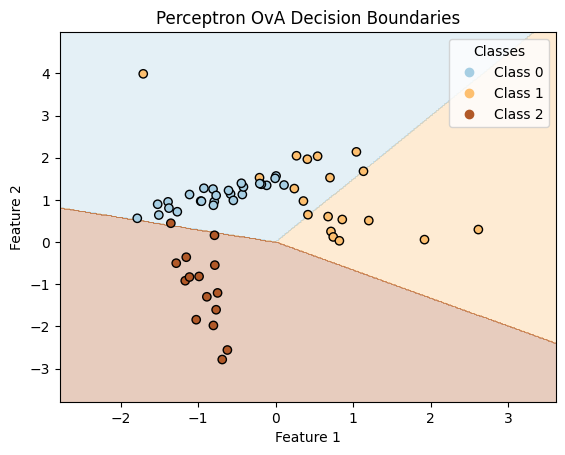

In [64]:
classifiers_ova = train_ova_perceptrons(X_test, y_test, num_classes)
# Plot decision boundaries for OvA Perceptron using the adapted function
plot_decision_boundaries_ova(X_test, y_test, classifiers_ova, num_classes)
plt.show()


**Perceptron algorithm for the ECOC framework with Sparse Random Coding and Inverse Hamming Decoding**

In [105]:
# 1. Define the Perceptron algorithm and error evaluation function
def Perceptron(X, Y, max_iter=1000):
    m = X.shape[1]
    w = np.random.randn(m)
    for _ in range(max_iter):
        misclassified = False
        for i in range(len(X)):
            if np.dot(w, X[i]) * Y[i] <= 0:
                w += Y[i] * X[i]
                misclassified = True
        if not misclassified:
            break
    return w

def Evaluate_error(w, X, Y):
    n = X.shape[0]
    misclassified_count = 0
    for i in range(n):
        if np.dot(w, X[i]) * Y[i] <= 0:
            misclassified_count += 1
    return misclassified_count / n

# 2. Generate the ECOC matrix using Sparse Random coding
def generate_ecoc_matrix(num_classes, num_classifiers):
    return np.random.choice([-1, 0, 1], size=(num_classes, num_classifiers), p=[0.25, 0.5, 0.25])

# 3. Train binary classifiers based on the ECOC matrix
def train_ecoc_classifiers(X, y, ecoc_matrix):
    classifiers = []
    for i in range(ecoc_matrix.shape[1]):
        binary_labels = np.array([ecoc_matrix[cls, i] for cls in y])
        binary_labels[binary_labels == 0] = -1
        w = Perceptron(X, binary_labels)
        classifiers.append(w)
    return classifiers

# 4. Define prediction and decision boundary visualization functions
def inverse_hamming_decoding(test_code, class_codes):
    return np.argmin(np.array([np.sum(test_code != code) for code in class_codes]))

def predict_ecoc(X, classifiers, ecoc_matrix):
    predictions = []
    for x in X:
        test_code = np.array([1 if np.dot(w, x) > 0 else -1 for w in classifiers])
        predicted_class = inverse_hamming_decoding(test_code, ecoc_matrix)
        predictions.append(predicted_class)
    return np.array(predictions)



In [107]:
# Function to calculate the accuracy of each classifier
def calculate_accuracy_per_classifier(X, y, classifiers, ecoc_matrix):
    accuracies = []
    for i, w in enumerate(classifiers):
        binary_labels = np.array([ecoc_matrix[cls, i] for cls in y])
        binary_labels[binary_labels == 0] = -1
        predictions = np.sign(np.dot(X, w))
        accuracy = np.mean(predictions == binary_labels)
        accuracies.append((i, accuracy))
    return accuracies

# Calculate the accuracy of each binary classifier
classifier_accuracies = calculate_accuracy_per_classifier(X_train, y_train, classifiers, ecoc_matrix)

# Function to calculate the overall accuracy of the ECOC model
def calculate_overall_accuracy(X, y, classifiers, ecoc_matrix):
    predictions = predict_ecoc(X, classifiers, ecoc_matrix)
    return np.mean(predictions == y)

# Calculate the overall accuracy of the ECOC model
overall_accuracy = calculate_overall_accuracy(X_test, y_test, classifiers, ecoc_matrix)

classifier_accuracies, overall_accuracy



([(0, 0.9333333333333333),
  (1, 0.6083333333333333),
  (2, 0.8958333333333334),
  (3, 0.5833333333333334),
  (4, 0.9416666666666667),
  (5, 0.5958333333333333),
  (6, 0.9291666666666667)],
 0.5333333333333333)

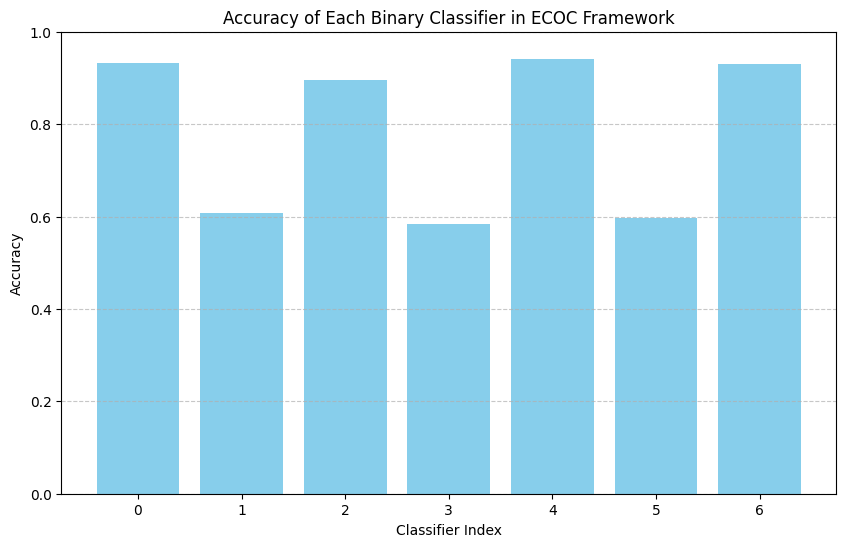

In [106]:
import matplotlib.pyplot as plt

# Extract classifier indices and their accuracies
classifier_indices, accuracies = zip(*classifier_accuracies)

# Plotting a histogram of classifier accuracies
plt.figure(figsize=(10, 6))
plt.bar(classifier_indices, accuracies, color='skyblue')
plt.xlabel('Classifier Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Binary Classifier in ECOC Framework')
plt.xticks(classifier_indices)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# ADALINE

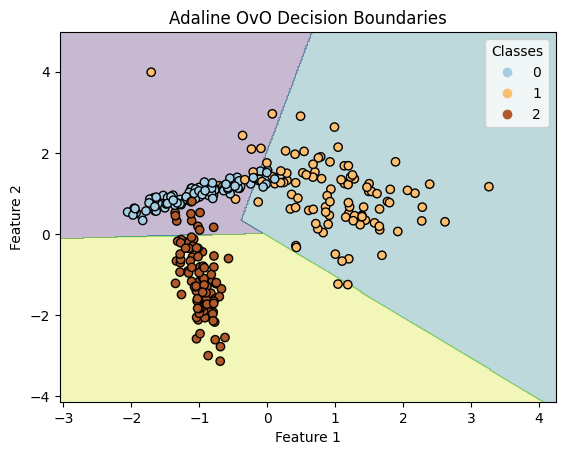

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Functions for Adaline OvO Classification
def add_bias(X):
    return np.hstack((np.ones((X.shape[0], 1)), X))

def Adaline(X, Y, lr=0.0001, delta=0.2, max_iter=100):
    n = X.shape[0]
    m = X.shape[1]
    w = np.random.randn(m)
    t = 0

    while t < max_iter:
        grad = -2 * np.dot(X.T, Y - np.dot(X, w)) / len(Y)
        if np.all(np.abs(grad) <= delta):
            break
        for i in range(n):
            update = lr * 2 * (Y[i] - np.dot(X[i], w)) * X[i]
            w += update
        t += 1
    return w

def train_ovo_adalines(X, y, num_classes):
    classifiers = {}
    X = add_bias(X)
    for class1, class2 in combinations(range(num_classes), 2):
        binary_filter = (y == class1) | (y == class2)
        X_binary = X[binary_filter]
        y_binary = np.where(y[binary_filter] == class1, 1, -1)
        w = Adaline(X_binary, y_binary)
        classifiers[(class1, class2)] = w
    return classifiers

def ovo_predict_adalines(classifiers, X, num_classes):
    X = add_bias(X)
    votes = np.zeros((X.shape[0], num_classes))
    for (class1, class2), w in classifiers.items():
        predictions = np.dot(X, w) > 0
        votes[:, class1] += predictions
        votes[:, class2] += ~predictions
    return np.argmax(votes, axis=1)

# Visualization function with legends
def plot_decision_boundaries(X, y, classifiers, num_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = ovo_predict_adalines(classifiers, mesh_points, num_classes)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Adaline OvO Decision Boundaries")
    plt.legend(handles=scatter.legend_elements()[0], title="Classes", labels=[0,1,2])





# Train OvO Adaline classifiers and plot decision boundaries
classifiers = train_ovo_adalines(X_train, y_train, num_classes)
plot_decision_boundaries(X, y, classifiers, num_classes)
plt.show()


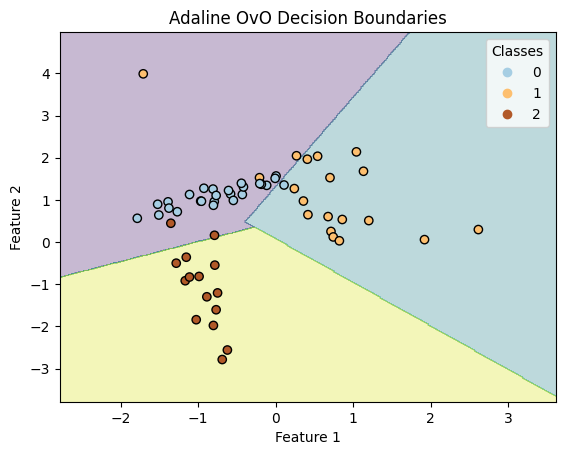

In [87]:
# TESTING: OvO Adaline classifiers and plot decision boundaries
classifiers = train_ovo_adalines(X_train, y_train, num_classes)
plot_decision_boundaries(X_test, y_test, classifiers, num_classes)
plt.show()


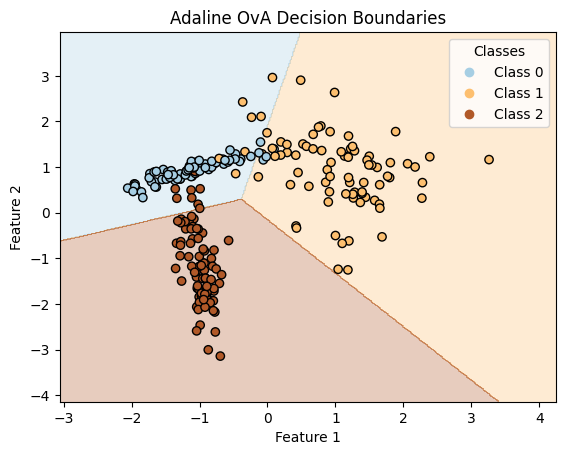

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.colors import ListedColormap

# Function to add bias term to the dataset
def add_bias(X):
    return np.hstack((np.ones((X.shape[0], 1)), X))

# Adaline training function
def Adaline(X, Y, lr=0.0001, delta=0.02, max_iter=5000):
    n = X.shape[0]
    m = X.shape[1]
    w = np.random.randn(m)
    t = 0

    while t < max_iter:
        grad = -2 * np.dot(X.T, Y - np.dot(X, w)) / len(Y)
        if np.all(np.abs(grad) <= delta):
            break
        for i in range(n):
            update = lr * 2 * (Y[i] - np.dot(X[i], w)) * X[i]
            w += update
        t += 1
    return w

# Function to train OvA Adaline classifiers
def train_ova_adalines(X, y, num_classes):
    classifiers = {}
    X = add_bias(X)  # Add bias term only once before the training
    for class_ in range(num_classes):
        # Create binary labels for the current class vs all other classes
        binary_y = np.where(y == class_, 1, -1)
        w = Adaline(X, binary_y)
        classifiers[class_] = w
    return classifiers

# Function to make predictions using OvA Adaline classifiers
def ova_predict_adalines(classifiers, X):
    X = add_bias(X)  # Add bias term only once before prediction
    predictions = np.array([np.dot(X, w) for w in classifiers.values()]).T
    return np.argmax(predictions, axis=1)

# Visualization function with distinct colors for each class region
def plot_decision_boundaries(X, y, classifiers, num_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = ova_predict_adalines(classifiers, mesh_points)
    Z = Z.reshape(xx.shape)

    # Create a custom color map from an array of colors
    colors_array = plt.cm.Paired(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors_array)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=custom_cmap)

    # Plot the training points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=custom_cmap)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Adaline OvA Decision Boundaries")

    # Generate a legend with the unique colors from the scatter plot
    unique_labels = np.unique(y)
    handles = [plt.Line2D([], [], marker='o', color=custom_cmap(i), linestyle='None') for i in range(len(unique_labels))]
    plt.legend(handles, [f'Class {l}' for l in unique_labels], title="Classes")



# Train OvA Adaline classifiers and plot decision boundaries
classifiers = train_ova_adalines(X_train, y_train, num_classes)
plot_decision_boundaries(X_train, y_train, classifiers, num_classes)
plt.show()


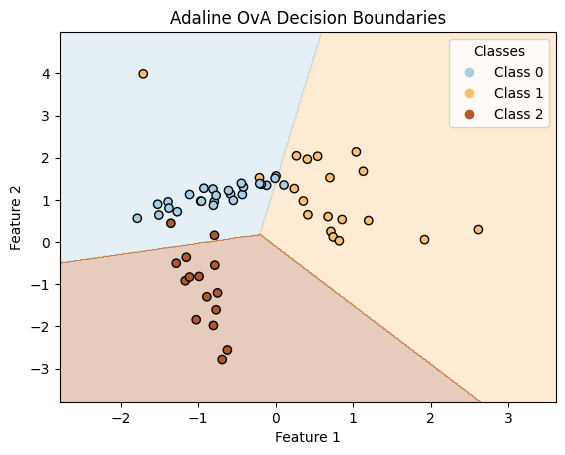

In [47]:
# Train OvA Adaline classifiers and plot decision boundaries
classifiers = train_ova_adalines(X_test, y_test, num_classes)
plot_decision_boundaries(X_test, y_test, classifiers, num_classes)
plt.show()


**Adaline algorithm for the ECOC framework with Sparse Random Coding and Inverse Hamming Decoding**

In [109]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Functions for Adaline
def add_bias(X):
    return np.hstack((np.ones((X.shape[0], 1)), X))

def Adaline(X, Y, lr=0.0001, delta=0.2, max_iter=100):
    m = X.shape[1]
    w = np.random.randn(m)
    t = 0
    while t < max_iter:
        grad = -2 * np.dot(X.T, Y - np.dot(X, w)) / len(Y)
        if np.all(np.abs(grad) <= delta):
            break
        w -= lr * grad
        t += 1
    return w

# Generating the ECOC matrix
def generate_ecoc_matrix(num_classes, num_classifiers):
    return np.random.choice([-1, 0, 1], size=(num_classes, num_classifiers), p=[0.25, 0.5, 0.25])

# Training binary classifiers with Adaline
def train_ecoc_adaline(X, y, ecoc_matrix, lr=0.0001, delta=0.2, max_iter=100):
    classifiers = []
    for i in range(ecoc_matrix.shape[1]):
        binary_labels = np.array([ecoc_matrix[cls, i] for cls in y])
        binary_labels[binary_labels == 0] = -1
        X_bias = add_bias(X)
        w = Adaline(X_bias, binary_labels, lr, delta, max_iter)
        classifiers.append(w)
    return classifiers

# Inverse Hamming Decoding function
def inverse_hamming_decoding(test_code, class_codes):
    return np.argmin(np.array([np.sum(test_code != code) for code in class_codes]))

# Predict function for ECOC with bias
def predict_ecoc_with_bias(X, classifiers, ecoc_matrix):
    predictions = []
    X_bias = add_bias(X)
    for x in X_bias:
        test_code = np.array([1 if np.dot(w, x) > 0 else -1 for w in classifiers])
        predicted_class = inverse_hamming_decoding(test_code, ecoc_matrix)
        predictions.append(predicted_class)
    return np.array(predictions)

# Accuracy calculation functions
def calculate_accuracy_per_classifier_with_bias(X, y, classifiers, ecoc_matrix):
    accuracies = []
    X_bias = add_bias(X)
    for i, w in enumerate(classifiers):
        binary_labels = np.array([ecoc_matrix[cls, i] for cls in y])
        binary_labels[binary_labels == 0] = -1
        predictions = np.sign(np.dot(X_bias, w))
        accuracy = np.mean(predictions == binary_labels)
        accuracies.append((i, accuracy))
    return accuracies

def calculate_overall_accuracy_with_bias(X, y, classifiers, ecoc_matrix):
    predictions = predict_ecoc_with_bias(X, classifiers, ecoc_matrix)
    return np.mean(predictions == y)


num_classes = len(np.unique(y_train))
num_classifiers = int(15 * np.log10(num_classes))
ecoc_matrix_adaline = generate_ecoc_matrix(num_classes, num_classifiers)
classifiers_adaline = train_ecoc_adaline(X_train, y_train, ecoc_matrix_adaline)

# Calculate accuracies
adaline_classifier_accuracies = calculate_accuracy_per_classifier_with_bias(X_train, y_train, classifiers_adaline, ecoc_matrix_adaline)
overall_accuracy_adaline = calculate_overall_accuracy_with_bias(X_test, y_test, classifiers_adaline, ecoc_matrix_adaline)

adaline_classifier_accuracies, overall_accuracy_adaline


([(0, 0.5125),
  (1, 0.5083333333333333),
  (2, 0.5666666666666667),
  (3, 1.0),
  (4, 0.15416666666666667),
  (5, 0.7041666666666667),
  (6, 0.5375)],
 0.2)

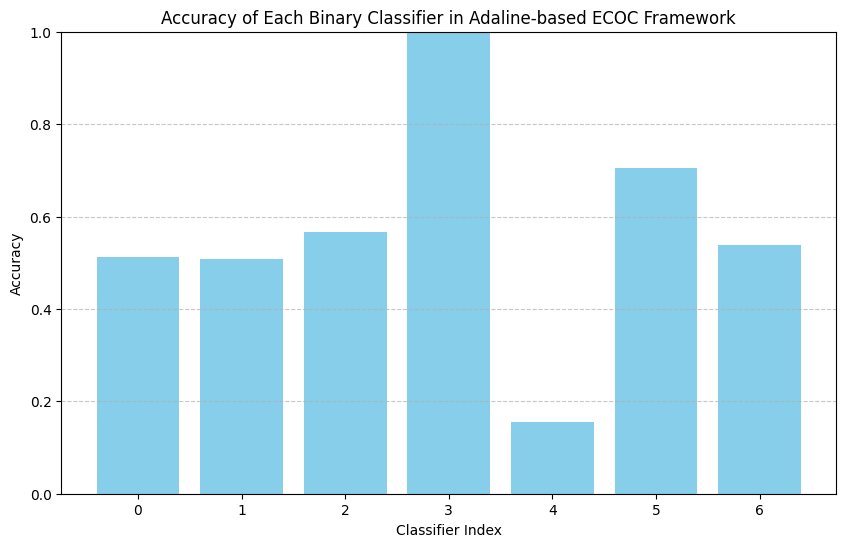

In [110]:
# Extracting classifier indices and their accuracies for plotting
classifier_indices, accuracies = zip(*adaline_classifier_accuracies)

# Plotting a histogram of classifier accuracies
plt.figure(figsize=(10, 6))
plt.bar(classifier_indices, accuracies, color='skyblue')
plt.xlabel('Classifier Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Binary Classifier in Adaline-based ECOC Framework')
plt.xticks(classifier_indices)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Logistic regression

**OVA**

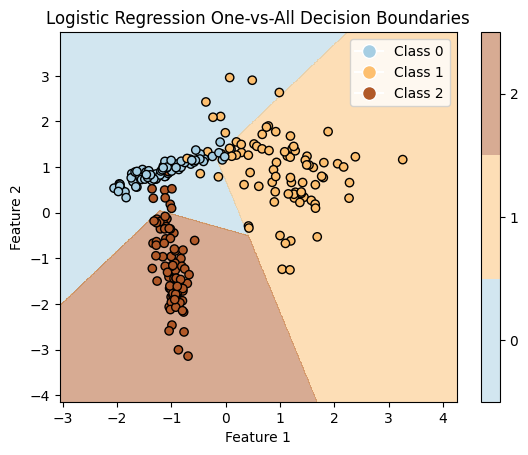

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Binary cross-entropy cost function
def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))

# Training function for logistic regression
def train_logistic_regression(X, y, learning_rate=0.01, iterations=1000):
    # Initialize weights and bias
    w = np.random.rand(X.shape[1])
    b = 0

    for i in range(iterations):
        # Compute model output
        z = np.dot(X, w) + b
        h = sigmoid(z)

        # Compute gradient
        gradient_w = np.dot(X.T, (h - y)) / y.size
        gradient_b = np.sum(h - y) / y.size

        # Update weights and bias
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b

    return w, b

# Function to predict labels using logistic regression
def predict_logistic_regression(X, w, b):
    z = np.dot(X, w) + b
    h = sigmoid(z)
    return h >= 0.5

# One-vs-All training
def train_one_vs_all_logistic_regression(X, y, num_classes, **kwargs):
    classifiers = {}
    for class_ in range(num_classes):
        # Create binary labels for the current class
        binary_y = (y == class_).astype(int)
        w, b = train_logistic_regression(X, binary_y, **kwargs)
        classifiers[class_] = (w, b)
    return classifiers

# One-vs-All prediction
def predict_one_vs_all_logistic_regression(X, classifiers):
    predictions = np.array([predict_logistic_regression(X, w, b) for class_, (w, b) in classifiers.items()])
    return np.argmax(predictions, axis=0)


def plot_decision_boundaries(X, y, classifiers, num_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Prepare the custom colormap
    colors = plt.cm.Paired(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors)

    # Predict each point in the mesh grid
    Z = predict_one_vs_all_logistic_regression(np.c_[xx.ravel(), yy.ravel()], classifiers)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5, cmap=custom_cmap, levels=np.arange(num_classes+1)-0.5)
    plt.colorbar(ticks=np.arange(num_classes))

    # Plot the training points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=custom_cmap)

    # Create a legend
    unique_labels = np.unique(y)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Class {int(l)}',
                                 markerfacecolor=custom_cmap(i), markersize=10) for i, l in enumerate(unique_labels)]
    plt.legend(handles=legend_handles)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Logistic Regression One-vs-All Decision Boundaries')

# Train the One-vs-All logistic regression model
classifiers = train_one_vs_all_logistic_regression(X_train, y_train, num_classes)

# Plot the decision boundaries
plot_decision_boundaries(X_train, y_train, classifiers, num_classes)
plt.show()


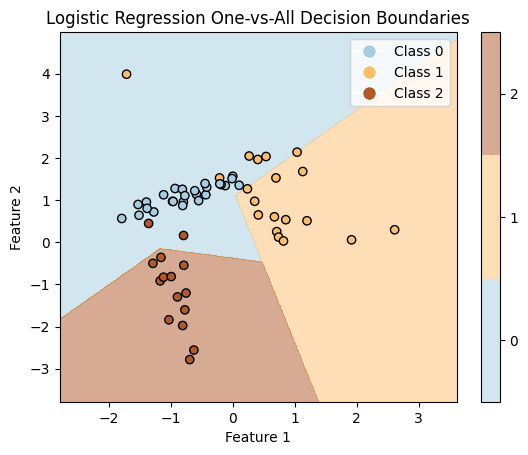

In [59]:
# Train the One-vs-All logistic regression model
classifiers = train_one_vs_all_logistic_regression(X_test, y_test, num_classes)

# Plot the decision boundaries
plot_decision_boundaries(X_test, y_test, classifiers, num_classes)
plt.show()

**OVO**

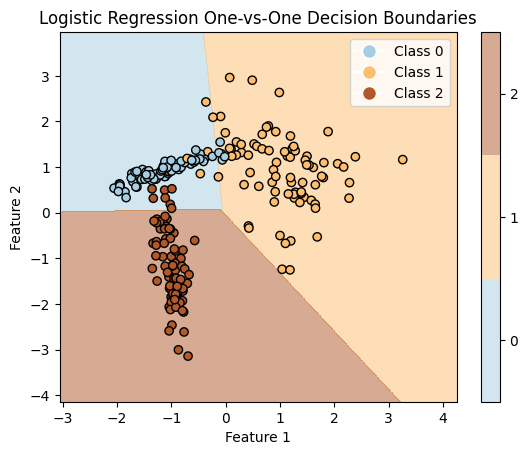

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations


# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Training function for logistic regression for OvO
def train_ovo_logistic_regression(X, y, num_classes, learning_rate=0.01, iterations=1000):
    classifiers = {}
    for class1, class2 in combinations(range(num_classes), 2):
        # Filter data for the current class pair
        binary_filter = (y == class1) | (y == class2)
        X_binary, y_binary = X[binary_filter], y[binary_filter]
        y_binary = np.where(y_binary == class1, 1, 0)

        # Initialize weights including the bias term
        w = np.zeros(X_binary.shape[1] + 1)

        # Add bias term to the features
        X_binary = np.hstack([np.ones((X_binary.shape[0], 1)), X_binary])

        for i in range(iterations):
            z = np.dot(X_binary, w)  # b is included in w as the first term
            h = sigmoid(z)
            gradient = np.dot(X_binary.T, (h - y_binary)) / y_binary.size
            w -= learning_rate * gradient

        classifiers[(class1, class2)] = w  # Store the weights including the bias term

    return classifiers

# Prediction function for OvO logistic regression
def predict_ovo_logistic_regression(X, classifiers, num_classes):
    # Initialize the votes for each class to zero
    votes = np.zeros((X.shape[0], num_classes))

    # Add bias term to the features
    X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

    # Predict for each classifier and tally the votes
    for (class1, class2), w in classifiers.items():
        predictions = sigmoid(np.dot(X_with_bias, w)) >= 0.5
        votes[:, class1] += predictions
        votes[:, class2] += (1 - predictions)

    # The final prediction is the class with the most votes
    return np.argmax(votes, axis=1)

# Visualization of decision boundaries
def plot_decision_boundaries(X, y, classifiers, num_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Prepare the custom colormap
    colors = plt.cm.Paired(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors)

    # Predict each point in the mesh grid
    Z = predict_ovo_logistic_regression(np.c_[xx.ravel(), yy.ravel()], classifiers, num_classes)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5, cmap=custom_cmap, levels=np.arange(num_classes+1)-0.5)
    plt.colorbar(ticks=np.arange(num_classes))

    # Plot the training points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=custom_cmap)

    # Create a legend
    unique_labels = np.unique(y)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Class {int(l)}',
                                 markerfacecolor=custom_cmap(i), markersize=10) for i, l in enumerate(unique_labels)]
    plt.legend(handles=legend_handles)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Logistic Regression One-vs-One Decision Boundaries')



# Train the One-vs-One logistic regression model
classifiers = train_ovo_logistic_regression(X_train, y_train, num_classes)

# Plot the decision boundaries
plot_decision_boundaries(X_train, y_train, classifiers, num_classes)
plt.show()


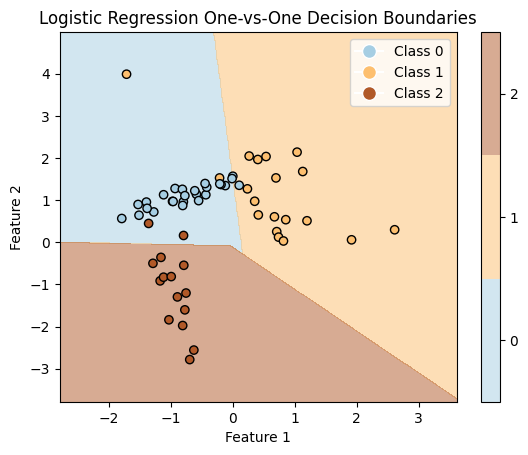

In [52]:
# Train the One-vs-One logistic regression model
classifiers = train_ovo_logistic_regression(X_test, y_test, num_classes)

# Plot the decision boundaries
plot_decision_boundaries(X_test, y_test, classifiers, num_classes)
plt.show()

In [119]:
import numpy as np

# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Binary cross-entropy cost function
def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))

# Training function for logistic regression (binary case)
def train_logistic_regression(X, y, learning_rate=0.01, iterations=1000):
    w = np.random.rand(X.shape[1])
    b = 0
    for i in range(iterations):
        z = np.dot(X, w) + b
        h = sigmoid(z)
        gradient_w = np.dot(X.T, (h - y)) / y.size
        gradient_b = np.sum(h - y) / y.size
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
    return w, b

# Function to predict labels using logistic regression (binary case)
def predict_logistic_regression(X, w, b):
    z = np.dot(X, w) + b
    h = sigmoid(z)
    return h >= 0.5

# Adapting to multi-class logistic regression using one-vs-rest approach
def train_multiclass_logistic_regression(X, y, num_classes, learning_rate=0.01, iterations=1000):
    classifiers = []
    for class_index in range(num_classes):
        y_binary = (y == class_index).astype(int)  # Binary label for the current class
        w, b = train_logistic_regression(X, y_binary, learning_rate, iterations)
        classifiers.append((w, b))
    return classifiers

def predict_multiclass_logistic_regression(X, classifiers):
    predictions = np.zeros((X.shape[0], len(classifiers)))
    for i, (w, b) in enumerate(classifiers):
        predictions[:, i] = sigmoid(np.dot(X, w) + b)
    return np.argmax(predictions, axis=1)


# Train the multi-class logistic regression model
classifiers = train_multiclass_logistic_regression(X_train, y_train, num_classes)

# Predict and evaluate on the test set
predictions = predict_multiclass_logistic_regression(X_test, classifiers)
accuracy = np.mean(predictions == y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8666666666666667


**Logistic regression algorithm for the ECOC framework with Sparse Random Coding and Inverse Hamming Decoding**

In [120]:
# Generate the ECOC matrix using Sparse Random coding
def generate_ecoc_matrix(num_classes, num_classifiers):
    # The probability of assigning '1' and '-1' is smaller than '0' to ensure sparsity
    return np.random.choice([-1, 0, 1], size=(num_classes, num_classifiers), p=[0.25, 0.25, 0.5])

# Function to train ECOC classifiers using logistic regression
def train_ecoc_logistic_regression(X, y, ecoc_matrix, learning_rate=0.01, iterations=1000):
    classifiers = []
    for i in range(ecoc_matrix.shape[1]):
        # Creating binary labels based on the ECOC matrix
        binary_labels = np.array([(ecoc_matrix[cls, i] if ecoc_matrix[cls, i] != 0 else -1) for cls in y])
        binary_labels = (binary_labels + 1) / 2  # Convert to 0 and 1
        w, b = train_logistic_regression(X, binary_labels, learning_rate, iterations)
        classifiers.append((w, b))
    return classifiers

# Inverse Hamming Decoding function
def inverse_hamming_decoding(test_code, class_codes):
    # Calculate Hamming distance between the test code and each class code
    hamming_distances = np.array([np.sum(test_code != code) for code in class_codes])
    # Select the class with the minimum Hamming distance
    return np.argmin(hamming_distances)

# Function to predict using ECOC classifiers
def predict_ecoc(X, classifiers, ecoc_matrix):
    predictions = []
    for x in X:
        # Generate the code for each test instance
        test_code = np.array([1 if predict_logistic_regression(x, w, b) else -1 for w, b in classifiers])
        # Predict the class using Inverse Hamming Decoding
        predicted_class = inverse_hamming_decoding(test_code, ecoc_matrix)
        predictions.append(predicted_class)
    return np.array(predictions)

# Generate the ECOC matrix
num_classifiers = int(15 * np.log10(num_classes))  # Number of classifiers based on Sparse Random coding
ecoc_matrix = generate_ecoc_matrix(num_classes, num_classifiers)

# Train ECOC classifiers using logistic regression
classifiers_ecoc = train_ecoc_logistic_regression(X_train, y_train, ecoc_matrix)

# Evaluate the performance of the ECOC model
predictions_ecoc = predict_ecoc(X_test, classifiers_ecoc, ecoc_matrix)
accuracy_ecoc = np.mean(predictions_ecoc == y_test)
accuracy_ecoc


0.8666666666666667

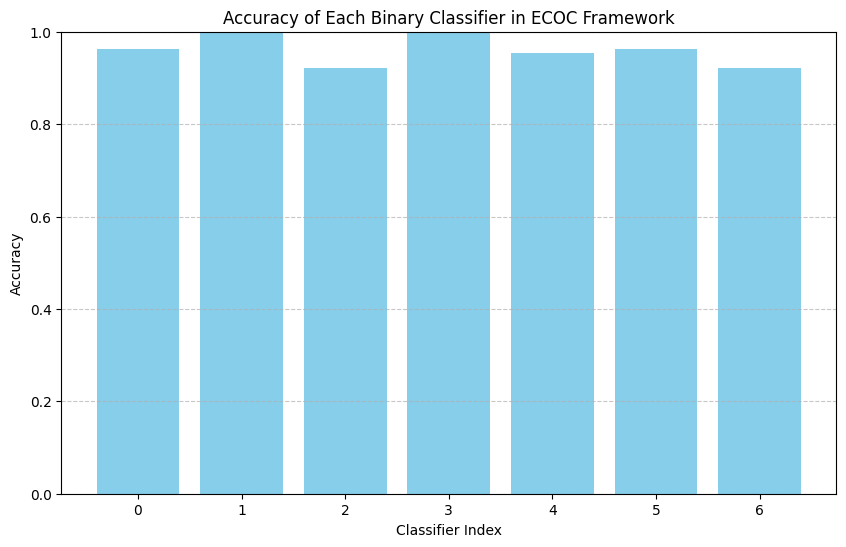

In [121]:
# Function to calculate the accuracy of each classifier within the ECOC framework
def calculate_accuracy_per_classifier_ecoc(X, y, classifiers, ecoc_matrix):
    accuracies = []
    for i, (w, b) in enumerate(classifiers):
        # Creating binary labels for each classifier based on the ECOC matrix
        binary_labels = np.array([(ecoc_matrix[cls, i] if ecoc_matrix[cls, i] != 0 else -1) for cls in y])
        binary_labels = (binary_labels + 1) / 2  # Convert to 0 and 1
        predictions = predict_logistic_regression(X, w, b)
        accuracy = np.mean(predictions == binary_labels)
        accuracies.append((i, accuracy))
    return accuracies

# Calculate the accuracy of each classifier
classifier_accuracies = calculate_accuracy_per_classifier_ecoc(X_train, y_train, classifiers_ecoc, ecoc_matrix)

# Extracting classifier indices and their accuracies for plotting
classifier_indices, accuracies = zip(*classifier_accuracies)

# Plotting a histogram of classifier accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(classifier_indices, accuracies, color='skyblue')
plt.xlabel('Classifier Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Binary Classifier in ECOC Framework')
plt.xticks(classifier_indices)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Pocket

In [122]:
import numpy as np
def Pocket(X, Y):
    n, m = X.shape
    w = np.random.randn(m)
    ws = w
    Tmax = 100

    for t in range(Tmax):
        misclassified_count = 0

        for i in range(n):
            if np.dot(w, X[i].T) * Y[i] <= 0:
                w += Y[i] * X[i]
                misclassified_count += 1

        Ls_W = misclassified_count / n
        Ls_Ws = Evaluate_error(ws, X, Y)

        if Ls_W < Ls_Ws:
            ws = w

    final_ws = ws
    final_time = Tmax
    final_error = Ls_Ws

    return final_ws, final_time, final_error

def Evaluate_error(w, X, Y):
    n = X.shape[0]
    misclassified_count = 0

    for i in range(n):
        if np.dot(w, X[i].T) * Y[i] <= 0:
            misclassified_count += 1

    error_rate = misclassified_count / n
    return error_rate





**OVO**

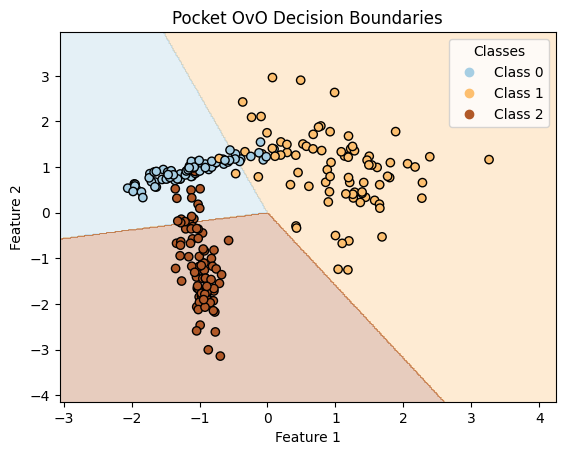

In [94]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

# Function to train pocket classifiers for OvO approach
def train_ovo_pocket(X, y, num_classes):
    classifiers = {}
    for class1, class2 in combinations(range(num_classes), 2):
        binary_filter = np.logical_or(y == class1, y == class2)
        X_binary = X[binary_filter]
        y_binary = np.where(y[binary_filter] == class1, 1, -1)

        w, _, _ = Pocket(X_binary, y_binary)
        classifiers[(class1, class2)] = w

    return classifiers

# Function to predict using the OvO pocket classifiers
def ovo_predict_pocket(classifiers, X, num_classes):
    votes = np.zeros((X.shape[0], num_classes))
    for (class1, class2), w in classifiers.items():
        for i, x in enumerate(X):
            prediction = 1 if np.dot(w, x.T) > 0 else -1
            votes[i, class1 if prediction == 1 else class2] += 1
    return np.argmax(votes, axis=1)

# Visualization function with distinct colors for each class region adapted for Pocket classifiers (OvO)
def plot_decision_boundaries_ovo_pocket(X, y, classifiers, num_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = ovo_predict_pocket(classifiers, mesh_points, num_classes)
    Z = Z.reshape(xx.shape)

    # Create a custom color map from an array of colors
    colors_array = plt.cm.Paired(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors_array)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=custom_cmap)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=custom_cmap)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Pocket OvO Decision Boundaries")

    # Generate a legend with the unique colors from the scatter plot
    unique_labels = np.unique(y)
    handles = [plt.Line2D([], [], marker='o', color=custom_cmap(i), linestyle='None') for i in range(len(unique_labels))]
    plt.legend(handles, [f'Class {l}' for l in unique_labels], title="Classes")



# Train OvO Pocket classifiers
classifiers_ovo_pocket = train_ovo_pocket(X_train, y_train, num_classes)

# Plot decision boundaries for OvO Pocket using the adapted function
plot_decision_boundaries_ovo_pocket(X_train, y_train, classifiers_ovo_pocket, num_classes)
plt.show()


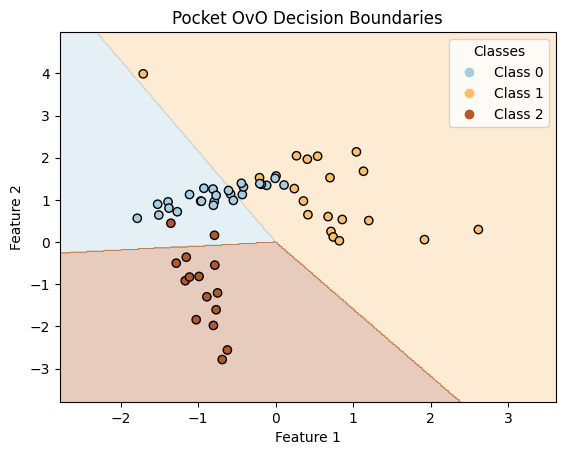

In [95]:
# Train OvO Pocket classifiers
classifiers_ovo_pocket = train_ovo_pocket(X_train, y_train, num_classes)

# Plot decision boundaries for OvO Pocket using the adapted function
plot_decision_boundaries_ovo_pocket(X_test, y_test, classifiers_ovo_pocket, num_classes)
plt.show()

**OVA**

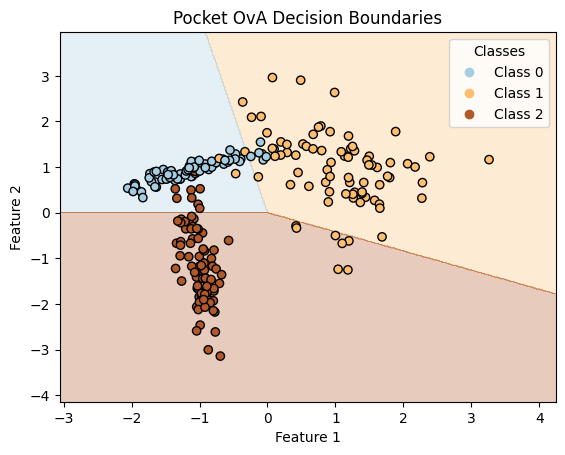

In [90]:
# Adapting the Pocket algorithm for One-vs-All classification

def train_ova_pocket(X, y, num_classes):
    classifiers = {}
    for current_class in range(num_classes):
        # Create binary labels for the current class vs all the rest
        y_binary = np.where(y == current_class, 1, -1)

        w, _, _ = Pocket(X, y_binary)
        classifiers[current_class] = w

    return classifiers

def ova_predict_pocket(classifiers, X):
    predictions = np.zeros((X.shape[0], len(classifiers)))
    for class_label, w in classifiers.items():
        predictions[:, class_label] = np.dot(X, w)
    return np.argmax(predictions, axis=1)

# Train OvA Pocket classifiers
classifiers_ova_pocket = train_ova_pocket(X_train, y_train, num_classes)

# Visualization function adapted for OvA Pocket classifiers
def plot_decision_boundaries_ova_pocket(X, y, classifiers, num_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = ova_predict_pocket(classifiers, mesh_points)
    Z = Z.reshape(xx.shape)

    # Create a custom color map from an array of colors
    colors_array = plt.cm.Paired(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors_array)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=custom_cmap)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=custom_cmap)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Pocket OvA Decision Boundaries")

    # Generate a legend with the unique colors from the scatter plot
    unique_labels = np.unique(y)
    handles = [plt.Line2D([], [], marker='o', color=custom_cmap(i), linestyle='None') for i in range(len(unique_labels))]
    plt.legend(handles, [f'Class {l}' for l in unique_labels], title="Classes")

# Plot decision boundaries for OvA Pocket using the adapted function
plot_decision_boundaries_ova_pocket(X_train, y_train, classifiers_ova_pocket, num_classes)
plt.show()


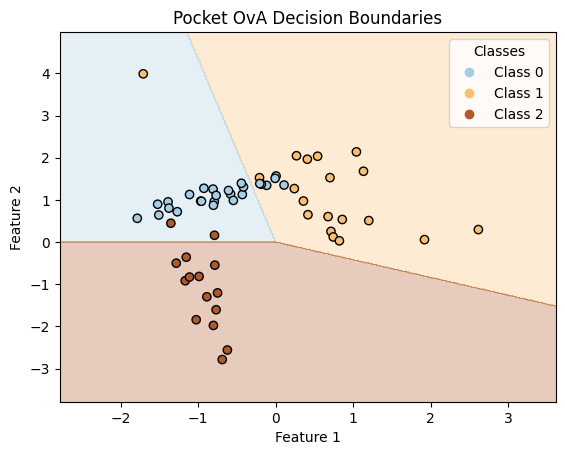

In [96]:
# Train OvO Pocket classifiers
classifiers_ovo_pocket = train_ova_pocket(X_train, y_train, num_classes)

# Plot decision boundaries for OvO Pocket using the adapted function
plot_decision_boundaries_ova_pocket(X_test, y_test, classifiers_ova_pocket, num_classes)
plt.show()

**Pocket algorithm for the ECOC framework with Sparse Random Coding and Inverse Hamming Decoding**

In [123]:
# Implementing the Pocket algorithm for the ECOC framework with Sparse Random Coding and Inverse Hamming Decoding

# Import necessary libraries
import numpy as np

# Pocket algorithm function
def Pocket(X, Y, Tmax=100):
    n, m = X.shape
    w = np.random.randn(m)
    ws = w  # Best weights
    for t in range(Tmax):
        misclassified_count = 0
        for i in range(n):
            if np.dot(w, X[i]) * Y[i] <= 0:
                w += Y[i] * X[i]
                misclassified_count += 1
        Ls_W = misclassified_count / n
        Ls_Ws = Evaluate_error(ws, X, Y)
        if Ls_W < Ls_Ws:
            ws = w
    return ws

# Error evaluation function for Pocket algorithm
def Evaluate_error(w, X, Y):
    n = X.shape[0]
    misclassified_count = 0
    for i in range(n):
        if np.dot(w, X[i]) * Y[i] <= 0:
            misclassified_count += 1
    return misclassified_count / n

# Function to train ECOC classifiers using Pocket algorithm
def train_ecoc_pocket(X, y, ecoc_matrix, Tmax=100):
    classifiers = []
    for i in range(ecoc_matrix.shape[1]):
        binary_labels = np.array([(ecoc_matrix[cls, i] if ecoc_matrix[cls, i] != 0 else -1) for cls in y])
        binary_labels = (binary_labels + 1) / 2  # Convert to 0 and 1
        ws = Pocket(X, binary_labels, Tmax)
        classifiers.append(ws)
    return classifiers

# Generate ECOC matrix
num_classes = len(np.unique(y))
num_classifiers = int(15 * np.log10(num_classes))  # Number of classifiers based on Sparse Random coding
ecoc_matrix = generate_ecoc_matrix(num_classes, num_classifiers)

# Train ECOC classifiers using Pocket algorithm
classifiers_pocket = train_ecoc_pocket(X_train, y_train, ecoc_matrix)

# Function to predict using ECOC classifiers with Pocket algorithm
def predict_ecoc_pocket(X, classifiers, ecoc_matrix):
    predictions = []
    for x in X:
        test_code = np.array([1 if np.dot(w, x) > 0 else -1 for w in classifiers])
        predicted_class = inverse_hamming_decoding(test_code, ecoc_matrix)
        predictions.append(predicted_class)
    return np.array(predictions)

# Evaluate the performance of the ECOC model using Pocket algorithm
predictions_pocket = predict_ecoc_pocket(X_test, classifiers_pocket, ecoc_matrix)
accuracy_pocket = np.mean(predictions_pocket == y_test)
accuracy_pocket


0.7833333333333333

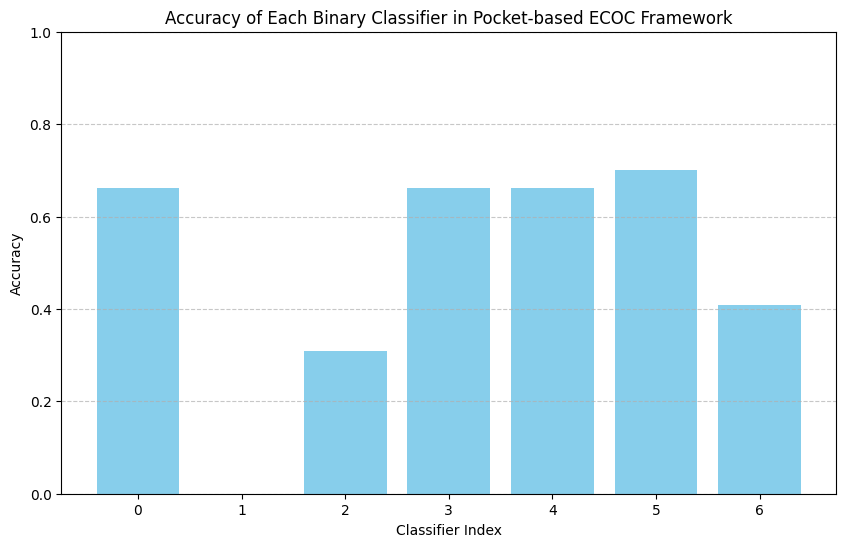

In [129]:
# Function to calculate the accuracy of each classifier within the ECOC framework using the Pocket algorithm
def calculate_accuracy_per_classifier_ecoc_pocket(X, y, classifiers, ecoc_matrix):
    accuracies = []
    for i, w in enumerate(classifiers):
        # Creating binary labels for each classifier based on the ECOC matrix
        binary_labels = np.array([(ecoc_matrix[cls, i] if ecoc_matrix[cls, i] != 0 else -1) for cls in y])
        binary_labels = (binary_labels + 1) / 2  # Convert to 0 and 1
        predictions = predict_pocket(X, w)
        accuracy = np.mean(predictions == binary_labels)
        accuracies.append((i, accuracy))
    return accuracies

# Calculate the accuracy of each classifier
classifier_accuracies_pocket = calculate_accuracy_per_classifier_ecoc_pocket(X_train, y_train, classifiers_pocket, ecoc_matrix)

# Extracting classifier indices and their accuracies for plotting
classifier_indices_pocket, accuracies_pocket = zip(*classifier_accuracies_pocket)

# Plotting a histogram of classifier accuracies
plt.figure(figsize=(10, 6))
plt.bar(classifier_indices_pocket, accuracies_pocket, color='skyblue')
plt.xlabel('Classifier Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Binary Classifier in Pocket-based ECOC Framework')
plt.xticks(classifier_indices_pocket)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
